<a href="https://colab.research.google.com/github/Kevan123/CostRewardOptimizationForBankLoanApprovals/blob/main/Bank_Delinquency_Interest_Rate_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Data Prep** 
a. Import packages/libraries \\
b. Import data \\
c. Clean up dataframe \\

In [18]:
import pandas as pd
import numpy as np
import random
from numpy.random.mtrand import rand
from random import gauss
from scipy.optimize import curve_fit
from matplotlib import pyplot
from numpy import arange
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('df_prepared_scored.xlsx', header=0, sheet_name= 'Sheet1')
#df = pd.read_excel('df_prepared_scored_new_prepared_scored.xlsx', header=0, sheet_name= 'Sheet1') #adjusted interest rates file to determine new return

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
df.head(5)

,MaskedID,Amt,Int_Rate,Ln_Tenure,Prim_Brnch_ID,Cust_Opn_Dt_parsed,Cust_Tenure,Acct_Opn_Dt_parsed,Ln_Reason_Msk,Birth_Dt_parsed,...,Salary,Mrtl_Status,Inc_Rng,Delinq,proba_0,proba_1,prediction,old_proba_1,difference,Time_Of_Delinq
0,15063xxxx6502,35300.0,15.00,3.002740,20,2000-09-27T00:00:00.000Z,21,2007-05-17T00:00:00.000Z,1-29,1982-02-07T00:00:00.000Z,...,,,,1,0.019954,0.980046,1,0.980046,0.0,0.491449
1,83126xxxx7303,50000.0,9.90,2.917808,5,1993-04-26T00:00:00.000Z,29,2009-12-17T00:00:00.000Z,1-9,1957-04-02T00:00:00.000Z,...,0,Married,"$0 - $4,999.99",1,0.019921,0.980079,1,0.980079,0.0,0.376597
2,32027xxxx5101,400000.0,10.75,2.920548,6,2001-04-18T00:00:00.000Z,21,2014-11-05T00:00:00.000Z,1-22,1967-10-02T00:00:00.000Z,...,0,Married,"$0 - $4,999.99",1,0.019895,0.980105,1,0.980105,0.0,0.519461
3,33028xxxx7401,30000.0,14.50,2.994521,14,2002-06-17T00:00:00.000Z,19,2016-06-28T00:00:00.000Z,1-9,1968-10-03T00:00:00.000Z,...,,,,1,0.019880,0.980120,1,0.980120,0.0,0.588067
4,33033xxxx7701,47000.0,7.50,1.419178,14,1990-08-21T00:00:00.000Z,31,2013-06-14T00:00:00.000Z,1-29,1967-06-12T00:00:00.000Z,...,0,Married,"$0 - $4,999.99",1,0.019873,0.980127,1,0.980127,0.0,0.534622


In [3]:
df.drop(df.columns[[4,5,6,7,8,9,10,11,12,13,14,15,16,17]], axis = 1, inplace = True)
#df.drop(df.columns[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,22,23]], axis = 1, inplace = True) #dropping additonal columns in the adjusted file

In [4]:
df.columns

Index(['MaskedID', 'Amt', 'Int_Rate', 'Ln_Tenure', 'Delinq', 'proba_0',
       'proba_1', 'prediction'],
      dtype='object')

In [5]:
df.dtypes

MaskedID       object
Amt           float64
Int_Rate      float64
Ln_Tenure     float64
Delinq        float64
proba_0       float64
proba_1       float64
prediction    float64
dtype: object

In [6]:
df.describe()

,Amt,Int_Rate,Ln_Tenure,Delinq,proba_0,proba_1,prediction
count,5.594300e+04,55943.000000,55943.000000,55943.000000,55943.000000,55943.000000,55943.000000
mean,1.214413e+05,9.383913,4.734344,0.100191,0.867086,0.132914,0.100138
std,2.521961e+05,3.002204,1.844681,0.300258,0.287201,0.287201,0.300186
min,0.000000e+00,0.000000,-8.591781,0.000000,0.000053,0.000026,0.000000
25%,5.000000e+04,7.250000,3.169863,0.000000,0.944397,0.003067,0.000000
50%,9.000000e+04,10.260000,4.920548,0.000000,0.990116,0.009884,0.000000
75%,1.600000e+05,11.400000,5.920548,0.000000,0.996933,0.055603,0.000000
max,3.000000e+07,25.000000,34.693151,1.000000,0.999974,0.999947,1.000000


### **2. Add in columns for:**
a. Loan Amt Plus Interest \\
b. Interest \\
c. Return \\

In [7]:
df["Amt_Plus_Int"] = df["Amt"]+(df["Amt"]*(df["Int_Rate"]/100))*df["Ln_Tenure"]
df["Int"] = df['Amt_Plus_Int'] - df['Amt']

In [8]:
df['prediction'] = df['prediction'].astype(int)
df['Delinq'] = df['Delinq'].astype(int)

In [ ]:
#df.drop(df.columns[[9]], axis = 1, inplace = True)

In [9]:
random.seed(25)
def time_delinq(row):
  if row['prediction'] == 1:
    return  gauss(0.5,0.1) ##mean of 0.5 and std dev of 0.1
  return 0

In [10]:
df['Time_Of_Delinq'] = df.apply(lambda row: time_delinq(row), axis=1)

In [11]:
df['Return'] = ((1-df['proba_1'])*df['Int']) + (df['proba_1']*(df['Time_Of_Delinq']*df['Int']))-((1-df['Time_Of_Delinq'])*df['Int'])

In [12]:
df.loc[df.prediction == 0, 'Return'] = df.Int

In [ ]:
df.to_excel('new_bank_delinquency_rate_optim.xlsx')

In [ ]:
df.head(10)

,Amt,Int_Rate,Ln_Tenure,Delinq,proba_0,proba_1,prediction,Time_Of_Delinq,Amt_Plus_Int,Int,Return
0,35300.0,15.00,3.002740,1,0.019954,0.980046,1,0.491449,51199.506849,15899.506849,-110.564635
1,50000.0,9.90,2.917808,1,0.019921,0.980079,1,0.376597,64443.150685,14443.150685,-3385.300927
2,400000.0,10.75,2.920548,1,0.019895,0.980105,1,0.519461,525583.561644,125583.561644,6088.517561
3,30000.0,14.50,2.994521,1,0.019880,0.980120,1,0.588067,43026.164384,13026.164384,2401.028814
4,47000.0,7.50,1.419178,1,0.019873,0.980127,1,0.534622,52002.602740,5002.602740,392.668662
5,220000.0,11.75,2.915068,1,0.019818,0.980182,1,0.669080,295354.520548,75354.520548,25976.116388
6,25000.0,14.50,2.917808,1,0.019807,0.980193,1,0.456175,35577.054795,10577.054795,-813.144645
7,300000.0,10.25,5.002740,1,0.019804,0.980196,1,0.541269,453834.246575,153834.246575,14094.737838
8,0.0,5.39,0.000000,1,0.019801,0.980199,1,0.479978,0.000000,0.000000,0.000000
9,300000.0,15.00,4.917808,1,0.019801,0.980199,1,0.531686,521301.369863,221301.369863,16076.247071


In [ ]:
#need to optimize values of I such P can decrease and R can increase but realistically - this may also influence the Amt & Ln_Tenure

### **Taking a specific cohort of customers to optimize their interest rate to give a greater return**

In [13]:
#df_sub = df.loc[(df['Int_Rate'] == 7.5) & (df['prediction'] <= 1)]
df_sub = df.loc[(df['prediction']==1) & (df['proba_1']>0.980)]

In [31]:
df_sub.tail(10)

,MaskedID,Amt,Int_Rate,Ln_Tenure,Delinq,proba_0,proba_1,prediction,Amt_Plus_Int,Int,Time_Of_Delinq,Return
9603,80082xxxx2101,500000.00,6.75,3.002740,0,0.008146,0.991854,1,6.013425e+05,101342.465753,0.565489,13632.375842
12407,44099xxxx6704,109900.00,14.50,2.101370,0,0.000760,0.999240,1,1.433864e+05,33486.379452,0.506481,446.591684
17152,74102xxxx0201,25000.00,12.75,1.915068,0,0.014472,0.985528,1,3.110428e+04,6104.280822,0.491634,-57.220880
21891,15103xxxx7401,70000.00,14.50,0.498630,0,0.012289,0.987711,1,7.506110e+04,5061.095890,0.635672,1395.959650
41139,27028xxxx2101,196000.00,9.56,5.002740,0,0.014671,0.985329,1,2.897393e+05,93739.335890,0.569272,13579.408286
42259,66072xxxx9801,1000000.00,9.50,4.917808,0,0.012362,0.987638,1,1.467192e+06,467191.780822,0.644170,136765.267638
55910,11014xxxx2902,1000000.00,7.50,2.923288,0,0.015762,0.984238,1,1.219247e+06,219246.575342,0.585758,39035.822591
55913,11097xxxx1201,500000.00,0.00,1.054795,0,0.009304,0.990696,1,5.000000e+05,0.000000,0.606122,0.000000
55924,18020xxxx5301,108000.00,14.00,4.920548,0,0.017687,0.982313,1,1.823987e+05,74398.684932,0.457605,-5594.560417
55938,51054xxxx7101,2368219.53,14.50,0.838356,0,0.017113,0.982887,1,2.656104e+06,287884.659030,0.539141,24806.449827


In [32]:
df_sub.describe()

,Amt,Int_Rate,Ln_Tenure,Delinq,proba_0,proba_1,prediction,Amt_Plus_Int,Int,Time_Of_Delinq,Return
count,3.197000e+03,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.0,3.197000e+03,3.197000e+03,3197.000000,3.197000e+03
mean,1.685614e+05,13.794697,2.782959,0.996872,0.005013,0.994987,1.0,2.357531e+05,6.719167e+04,0.502834,9.453027e+02
std,5.873567e+05,3.932314,1.594299,0.055849,0.005142,0.005142,0.0,7.708091e+05,2.691035e+05,0.100618,5.826423e+04
min,0.000000e+00,0.000000,-8.591781,0.000000,0.000053,0.980046,1.0,-1.169315e+04,-1.116932e+05,0.194886,-1.278179e+06
25%,2.950000e+04,11.750000,1.917808,1.000000,0.001053,0.992339,1.0,3.673969e+04,7.656164e+03,0.436232,-2.055935e+03
50%,5.684216e+04,13.750000,2.920548,1.000000,0.002927,0.997073,1.0,7.872791e+04,1.977740e+04,0.503670,5.140536e+00
75%,1.300000e+05,16.000000,3.758904,1.000000,0.007661,0.998947,1.0,1.864663e+05,5.063466e+04,0.572125,2.517912e+03
max,2.000000e+07,25.000000,20.013699,1.000000,0.019954,0.999947,1.0,2.130356e+07,6.074893e+06,0.835303,1.848023e+06


### **3. Create quadratic function for a specific cohort**

In [14]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

y = 759.44824 * x + -31.85970 * x^2 + -2975.86140


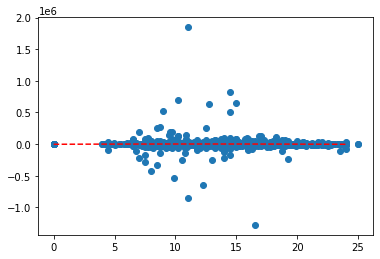

In [30]:
# choose the input and output variables
x = df_sub.iloc[:,2]
y = df_sub.iloc[:,-1]
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

### **4. Optimize interest rate to yield higher return**

In [16]:
check_input = True
while check_input:
    a, b, c = eval(input("Please enter the a, b, c coefficients of your quadratic equation: "))
    try: 
        float(a), float(b), float(c)
        check_input = False
    except ValueError:
        print("Please make sure the coefficients are real numbers and try again")
        check_input = True

disc = b*b-4*a*c

if disc >= 0:
    x1 = (-b+sqrt(disc))/(2*a)
    x2 = (-b-sqrt(disc))/(2*a)
    print("The roots of the equation are:", x1, x2)
else:
    print("The equation has no solutions")

Please enter the a, b, c coefficients of your quadratic equation: 759.44824, -31.85970, -2975.86140
The roots of the equation are: 2.000594681009167 -1.9586435666053728


In [29]:
max_y = max(y_line)  # Find the maximum y value
max_x = x_line[y_line.argmax()]  # Find the x value corresponding to the maximum y value
print (max_x, max_y)

12.0 1549.720362395697


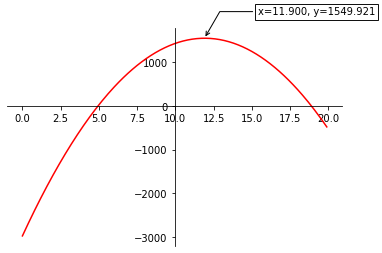

In [28]:
x = np.arange(0, 20, 0.1)
y = 759.44824 * x + -31.85970 * x**2 + -2975.86140

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.92)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(1.1,1.1), **kw)

annot_max(x,y)
# plot the function
plt.plot(x, y, 'r')

# show the plot
plt.show()

In [ ]:
df.to_excel('new_bank_delinquency_rate_optim.xlsx')

### 5. Adjust interest rates on cohort of customers whose delinquency is greater that 0.98 to 11.9% and compare returns

In [48]:
df1 = pd.read_excel('df_prepared_scored_new_scored(1).xlsx', header=0, sheet_name= 'Sheet1')

In [50]:
df1.drop(df1.columns[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,22]], axis = 1, inplace = True)

In [52]:
df1["Amt_Plus_Int"] = df1["Amt"]+(df1["Amt"]*(df1["Int_Rate"]/100))*df1["Ln_Tenure"]
df1["Int"] = df1['Amt_Plus_Int'] - df1['Amt']

In [53]:
df1['prediction'] = df1['prediction'].astype(int)
df1['Delinq'] = df1['Delinq'].astype(int)

In [60]:
df1.dtypes

MaskedID         object
Amt             float64
Int_Rate        float64
Ln_Tenure       float64
Delinq            int64
proba_0         float64
proba_1         float64
prediction        int64
Amt_Plus_Int    float64
Int             float64
dtype: object

In [62]:
df1 =  pd.merge(df1, df, on = "MaskedID", how='inner')

In [64]:
df1['Return_x'] = ((1-df1['proba_1_x'])*df1['Int_x']) + (df1['proba_1_x']*(df1['Time_Of_Delinq']*df1['Int_x']))-((1-df1['Time_Of_Delinq'])*df1['Int_x'])

In [73]:
df1.head(5)

,MaskedID,Amt_x,Int_Rate_x,Ln_Tenure_x,Delinq_x,proba_0_x,proba_1_x,prediction_x,Amt_Plus_Int_x,Int_x,...,Ln_Tenure_y,Delinq_y,proba_0_y,proba_1_y,prediction_y,Amt_Plus_Int_y,Int_y,Time_Of_Delinq,Return,Return_x
3616,35045xxxx2907,251000.0,11.9,0.336986,1,0.001277,0.998723,1,261065.443836,10065.443836,...,0.336986,1,0.000072,0.999928,1,267916.712329,16916.712329,0.650894,5105.670476,3042.107821
3617,20472xxxx7402,15000.0,11.9,0.915068,1,0.002400,0.997600,1,16633.397260,1633.397260,...,0.915068,1,0.000072,0.999928,1,17779.520548,2779.520548,0.622482,680.959857,401.604709
3618,29039xxxx9103,0.0,11.9,0.186301,1,0.000098,0.999902,1,0.000000,0.000000,...,0.186301,1,0.000070,0.999930,1,0.000000,0.000000,0.366099,0.000000,0.000000
3619,34037xxxx5401,555000.0,11.9,0.747945,1,0.000804,0.999196,1,604398.041096,49398.041096,...,0.747945,1,0.000054,0.999946,1,623493.082192,68493.082192,0.491142,-1211.508130,-854.896499
3620,34037xxxx5401,555000.0,11.9,0.747945,1,0.000804,0.999196,1,604398.041096,49398.041096,...,4.912329,0,0.987139,0.012861,0,125789.726027,25789.726027,0.000000,25789.726027,-49358.322095


In [112]:
df1_original = df1[(df1['Int_Rate_y'] > 11.9) & 
          df1['Delinq_y']==1] 
mean_orig = df1_original['Return'].mean()
mean_orig

34.2864729517766

In [113]:
df1_adjusted = df1[(df1['Int_Rate_x']== 11.9) & 
          df1['Delinq_y']==1] 
mean_adj = df1_adjusted['Return_x'].mean()
mean_adj

1314.5653035397559

In [115]:
inc = ((mean_adj/mean_orig) - 1)
inc

37.34063962743184